In [3]:
pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 17.7 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=41b5a4769bf4c3b3da3d744cb67de0ac7438d78d6f0dbe1de0e4c2e0771e9e29
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models
Note: you may need to restart the kernel to use updated packages.


### 

In [14]:
import os
from imutils import paths
import face_recognition
import pickle
import cv2

DATASET_PATH = "/kaggle/input/face-recognition-dataset/Original Images"

print("[INFO] start processing faces...")
imagePaths = list(paths.list_images(DATASET_PATH))
knownEncodings = []
knownNames = []

for (i, imagePath) in enumerate(imagePaths):
    print(f"[INFO] processing image {i + 1}/{len(imagePaths)}")
    name = imagePath.split(os.path.sep)[-2]  # Extract folder name as label
    
    image = cv2.imread(imagePath)
    if image is None:
        print(f"[WARNING] Could not read image {imagePath}, skipping.")
        continue

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = face_recognition.face_locations(rgb, model="hog")
    encodings = face_recognition.face_encodings(rgb, boxes)

    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)

print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
with open("encodings.pickle", "wb") as f:
    f.write(pickle.dumps(data))

print("[INFO] Training complete. Encodings saved to 'encodings.pickle'")


[INFO] start processing faces...
[INFO] processing image 1/2562
[INFO] processing image 2/2562
[INFO] processing image 3/2562
[INFO] processing image 4/2562
[INFO] processing image 5/2562
[INFO] processing image 6/2562
[INFO] processing image 7/2562
[INFO] processing image 8/2562
[INFO] processing image 9/2562
[INFO] processing image 10/2562
[INFO] processing image 11/2562
[INFO] processing image 12/2562
[INFO] processing image 13/2562
[INFO] processing image 14/2562
[INFO] processing image 15/2562
[INFO] processing image 16/2562
[INFO] processing image 17/2562
[INFO] processing image 18/2562
[INFO] processing image 19/2562
[INFO] processing image 20/2562
[INFO] processing image 21/2562
[INFO] processing image 22/2562
[INFO] processing image 23/2562
[INFO] processing image 24/2562
[INFO] processing image 25/2562
[INFO] processing image 26/2562
[INFO] processing image 27/2562
[INFO] processing image 28/2562
[INFO] processing image 29/2562
[INFO] processing image 30/2562
[INFO] processin

### Test on single image 

In [5]:
import face_recognition
import cv2
import pickle
import os

# Load encodings
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

# Replace this with your actual image
image_path = "/kaggle/input/wissem/1.jpg"

# Check file exists
if not os.path.exists(image_path):
    print(f"[ERROR] Image not found at: {image_path}")
    exit()

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"[ERROR] Failed to read image: {image_path}")
    exit()

# Convert to RGB
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect and encode
boxes = face_recognition.face_locations(rgb, model="hog")
encodings = face_recognition.face_encodings(rgb, boxes)

for (box, encoding) in zip(boxes, encodings):
    matches = face_recognition.compare_faces(data["encodings"], encoding)
    name = "Unknown"

    if True in matches:
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {}
        for i in matchedIdxs:
            counts[data["names"][i]] = counts.get(data["names"][i], 0) + 1
        name = max(counts, key=counts.get)

    # Draw result
    (top, right, bottom, left) = box
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
    cv2.putText(image, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

cv2.imwrite("output.jpg", image)
print("Output image saved to output.jpg")


Output image saved to output.jpg


In [15]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


{'train_accuracy': 0.9830246913580247,
 'val_accuracy': 0.9876543209876543,
 'confusion_matrix': array([[12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 22,  0,  0,  

In [16]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.15, random_state=42
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


{'train_accuracy': 0.9845665002269632,
 'val_accuracy': 0.9717223650385605,
 'confusion_matrix': array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 11,  0,  0,  

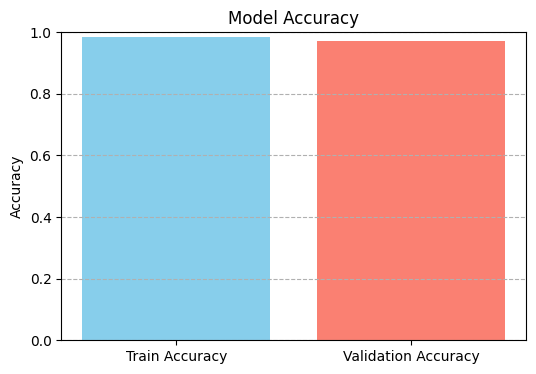

In [17]:
# Accuracy comparison bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--')
plt.show()

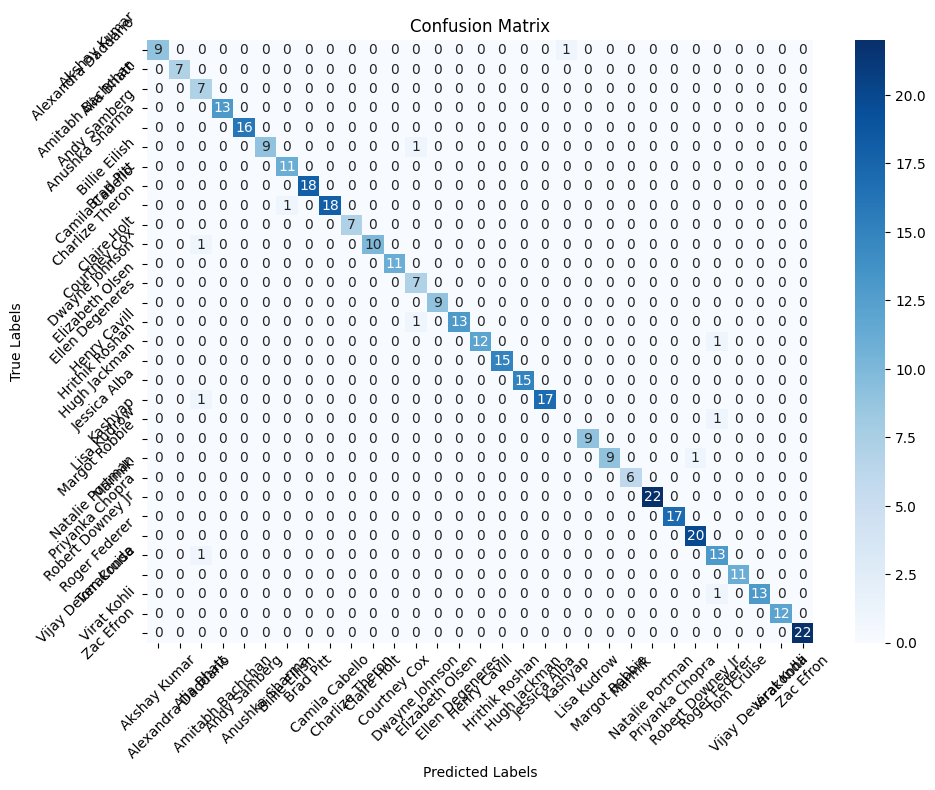

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred))


Classification Report:

                    precision    recall  f1-score   support

      Akshay Kumar       1.00      0.90      0.95        10
Alexandra Daddario       1.00      1.00      1.00         7
        Alia Bhatt       0.70      1.00      0.82         7
  Amitabh Bachchan       1.00      1.00      1.00        13
      Andy Samberg       1.00      1.00      1.00        16
    Anushka Sharma       1.00      0.90      0.95        10
     Billie Eilish       0.92      1.00      0.96        11
         Brad Pitt       1.00      1.00      1.00        18
    Camila Cabello       1.00      0.95      0.97        19
   Charlize Theron       1.00      1.00      1.00         7
       Claire Holt       1.00      0.91      0.95        11
      Courtney Cox       1.00      1.00      1.00        11
    Dwayne Johnson       0.78      1.00      0.88         7
   Elizabeth Olsen       1.00      1.00      1.00         9
   Ellen Degeneres       1.00      0.93      0.96        14
      Henry Cav

In [24]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.14.0


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input

from tensorflow.keras.utils import to_categorical
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load encodings
with open("/kaggle/input/testtttttttt/encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Filter classes with at least 2 samples
from collections import Counter
class_counts = Counter(y)
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_cat = to_categorical(y_encoded)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_cat, test_size=0.25, random_state=42, stratify=y_cat
)

# Build model
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Save model
model.save("face_classifier_nn.h5")

# === Plot training history ===
plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.0534 - loss: 7.0048 - val_accuracy: 0.0814 - val_loss: 6.3493
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0897 - loss: 6.2131 - val_accuracy: 0.1213 - val_loss: 5.8590
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1322 - loss: 5.8106 - val_accuracy: 0.1671 - val_loss: 5.5306
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1591 - loss: 5.4665 - val_accuracy: 0.1839 - val_loss: 5.2531
Epoch 5/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1758 - loss: 5.1990 - val_accuracy: 0.2162 - val_loss: 4.9881
Epoch 6/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1985 - loss: 4.9375 - val_accuracy: 0.2445 - val_loss: 4.7998
Epoch 7/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2151 - loss: 4.7220 - val_accuracy: 0.2565 - val_loss: 4.6167
Epoch 8/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2248 - loss: 4.5006 - val_accu